In [7]:
import seml
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
seml_results = seml.get_results('rgnn_rpprgo_papers100M', to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])


/nfs/homedirs/schmidtt/miniconda3/lib/python3.8/site-packages/seml/evaluation.py:48: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [10]:
seml_results_orig = seml_results.copy()

In [11]:
seml_results = seml_results_orig.copy()

In [12]:
len(seml_results)

355

In [13]:
relevant_columns = [#'_id', 
       "_id",
       'config.model_params.label',
       #'config.model_params.model',
       'result.accuracy',
        'config.model_params.alpha',
        'config.model_params.hidden_size',
       'config.model_params.nlayers',
       'config.train_params.batch_size',
       'config.train_params.lr',
       'config.train_params.weight_decay', 
        'config.model_params.dropout', 
        'config.model_params.eps',
        'config.model_params.topk', 
        #'config.model_params.mean',
       #'config.model_params.mean_kwargs.temperature',
       'config.dataset', 
       'config.seed',
        #'config.model_params.batch_norm',
       #'config.model_params.n_filters',
       #'config.model_params.gdc_params', 
       #'config.model_params.svd_params',
       #'config.model_params.jaccard_params',
       #'config.model_params.mean_kwargs.k',
       #'config.model_params.mean_kwargs.with_weight_correction',
       #'config.model_params.do_cache_adj_prep', 
       #"config.normalize",
       #'config.model_params.ppr_normalization','config.train_params.patience',
       'config.train_params.max_epochs', 
       #'config.train_params.batch_mult_val',
       # 'config.binary_attr', 
       #'config.artifact_dir', 'config.model_storage_type', 'config.device',
       #'config.display_steps', 'config.data_device', 'config.data_dir',
       # 'result.trace_val', 'result.trace_train',
       'result.model_path'
       ]
seml_results.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.nodes', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.model_params.label',
       'config.model_params.model', 'config.model_params.dropout',
       'config.model_params.n_filters', 'config.model_params.gdc_params',
       'config.model_params.svd_params', 'config.model_params.jaccard_params',
       'config.model_params.do_cache_adj_prep', 'config.model_params.alpha',
       'config.model_params.eps', 'config.model_params.hidden_size',
       'config.model_params.mean',
       'config.model_params.mean_kwargs.temperature',
       'config.model_params.nlayers', 'config.model_params.ppr_normalizati

In [14]:
seml_results.iloc[252]

_id                                                                                          423
batch_id                                                                                     113
slurm.experiments_per_job                                                                      1
slurm.sbatch_options.gres                                                                  gpu:1
slurm.sbatch_options.mem                                                                    230G
slurm.sbatch_options.cpus-per-task                                                             4
slurm.sbatch_options.time                                                                 1-0:00
slurm.sbatch_options.nodes                                                                     1
slurm.sbatch_options.job-name                                          rgnn_papers100M_train_113
slurm.sbatch_options.array                                                                   0-0
slurm.sbatch_options.output   

In [15]:
seml_results["config.seed"].unique()

array([0, 3])

In [16]:
seml_results[seml_results['_id'] >= 240][relevant_columns].sort_values(["result.accuracy",'config.train_params.max_epochs','config.model_params.hidden_size', 'config.model_params.nlayers', ], ascending=False) 

,_id,config.model_params.label,result.accuracy,config.model_params.alpha,config.model_params.hidden_size,config.model_params.nlayers,config.train_params.batch_size,config.train_params.lr,config.train_params.weight_decay,config.model_params.dropout,config.model_params.eps,config.model_params.topk,config.dataset,config.seed,config.train_params.max_epochs,result.model_path
331,518,Vanilla PPRGo Diffusion Embedding,0.637405,0.001000,640,7,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,10,cache/papers100M_hpt/papers100M_hpt_26.pt
334,521,Vanilla PPRGo Diffusion Embedding,0.635062,0.005000,768,5,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,5,cache/papers100M_hpt/papers100M_hpt_32.pt
333,520,Vanilla PPRGo Diffusion Embedding,0.635011,0.001000,768,5,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,10,cache/papers100M_hpt/papers100M_hpt_27.pt
332,519,Vanilla PPRGo Diffusion Embedding,0.634801,0.001000,640,6,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,10,cache/papers100M_hpt/papers100M_hpt_25.pt
314,497,Vanilla PPRGo Diffusion Embedding,0.632282,0.100000,768,5,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,5,cache/papers100M_hpt/papers100M_hpt_9.pt
349,536,Vanilla PPRGo Diffusion Embedding,0.631936,0.005000,640,7,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,5,cache/papers100M_hpt/papers100M_hpt_45.pt
305,488,Vanilla PPRGo Diffusion Embedding,0.631489,0.100000,640,7,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,5,cache/papers100M_hpt/papers100M_hpt_4.pt
337,524,Vanilla PPRGo Diffusion Embedding,0.630961,0.005000,896,5,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,5,cache/papers100M_hpt/papers100M_hpt_35.pt
329,516,Vanilla PPRGo Diffusion Embedding,0.628792,0.200000,640,7,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,0,10,cache/papers100M_hpt/papers100M_hpt_24.pt
303,486,Vanilla PPRGo Diffusion Embedding,0.627686,0.100000,640,6,512,0.0010,0.000000,0.00,1.000000e-06,512,ogbn-papers100M,3,5,cache/papers100M_noselfloop/papers100M_noselfl...


In [22]:
#seml_results.sort_values(["config.model_params.label", "result.accuracy"], ascending=False)[relevant_columns] 
seml_results.iloc[137]


_id                                                                                          285
batch_id                                                                                      29
slurm.experiments_per_job                                                                      1
slurm.sbatch_options.gres                                                                  gpu:1
slurm.sbatch_options.mem                                                                     20G
slurm.sbatch_options.cpus-per-task                                                             4
slurm.sbatch_options.time                                                                 0-2:00
slurm.sbatch_options.nodes                                                                     1
slurm.sbatch_options.job-name                                             rgnn_products_train_29
slurm.sbatch_options.array                                                                   0-9
slurm.sbatch_options.output   

In [21]:
seml_results[seml_results['config.model_params.model'] == "RobustPPRGo"][relevant_columns].sort_values(["result.accuracy",'config.train_params.max_epochs','config.model_params.hidden_size', 'config.model_params.nlayers', ], ascending=False) 

,_id,config.model_params.label,result.accuracy,config.model_params.alpha,config.model_params.hidden_size,config.model_params.nlayers,config.train_params.batch_size,config.train_params.lr,config.train_params.weight_decay,config.model_params.dropout,config.model_params.eps,config.model_params.topk,config.dataset,config.seed,config.train_params.max_epochs,result.model_path
137,285,Soft Median PPRGo (T=5.0),0.678967,0.10,512,4,10240,0.01,0.000050,0.15,0.0001,64,ogbn-products,0,30,cache/products/products_29.pt
138,286,Soft Median PPRGo (T=5.0),0.678204,0.10,512,4,10240,0.01,0.000050,0.20,0.0001,64,ogbn-products,0,30,cache/products/products_27.pt
78,222,Soft Median PPRGo (T=5.0),0.676752,0.10,512,4,10240,0.01,0.000020,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
77,221,Soft Median PPRGo (T=5.0),0.676273,0.10,512,4,10240,0.01,0.000010,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
76,220,Soft Median PPRGo (T=5.0),0.675302,0.10,512,4,10240,0.01,0.000005,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
139,289,Soft Median PPRGo (T=5.0),0.675201,0.10,512,4,10240,0.01,0.000000,0.20,0.0001,64,ogbn-products,0,30,cache/products/products_27.pt
79,223,Soft Median PPRGo (T=5.0),0.675117,0.10,512,4,10240,0.01,0.000050,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
80,224,Soft Median PPRGo (T=5.0),0.675061,0.10,512,4,10240,0.01,0.000080,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
75,219,Soft Median PPRGo (T=5.0),0.674365,0.10,512,4,10240,0.01,0.000000,0.25,0.0001,64,ogbn-products,0,30,cache/products/products_19.pt
73,217,Soft Median PPRGo (T=5.0),0.663079,0.10,512,4,10240,0.01,0.000050,0.00,0.0001,64,ogbn-products,0,30,cache/products/products_14.pt


In [106]:
def custom_round(x, base=5):
    return base * round(float(x)/base)

In [23]:
seml_results = seml_results_orig.copy()
groups = [
"config.dataset",
'config.model_params.label',
# "config.model_params.model",
#"alpha.quantile",
# "config.model_params.mean",
# 'config.model_params.mean_kwargs.temperature',
#"config.model_params.n_filters",
#"config.binary_attr",
# "config.model_params.ppr_normalization",
#'alpha.round',
"config.model_params.alpha",
# # "config.normalize",
# "config.model_params.topk",
 "config.model_params.hidden_size",
 "config.model_params.nlayers",
 "config.model_params.eps",
 "config.model_params.dropout",
 "config.train_params.lr",
 "config.train_params.weight_decay",
'config.train_params.use_annealing_scheduler',
 'config.model_params.batch_norm',
'config.train_params.lr',
'config.train_params.weight_decay',
]
#seml_results = seml_results[seml_results["config.dataset"]=="cora_ml"]
# seml_results = seml_results[seml_results["config.binary_attr"]==False]
#seml_results = seml_results[seml_results["config.normalize"]==False]

#seml_results = seml_results[seml_results['config.seed'] <= 100]
#seml_results = seml_results[seml_results['config.model_params.batch_norm'] == False]

#seml_results = seml_results[seml_results['config.model_params.mean_kwargs.temperature']!=5.0]
#seml_results = seml_results[~seml_results['config.model_params.batch_norm'].isna()]

#seml_results = seml_results[seml_results['config.train_params.weight_decay']!=0.05]

# seml_results = seml_results[seml_results['config.model_params.dropout']!=0.25]
# seml_results = seml_results[seml_results['config.model_params.nlayers']==2]
# seml_results = seml_results[seml_results['config.model_params.hidden_size']==64]
# seml_results["config.model_params.mean_kwargs.temperature"].fillna(0.0, inplace=True)
# seml_results["config.model_params.mean"].fillna("None", inplace=True)
# seml_results["config.model_params.batch_norm"].fillna("NaN", inplace=True)
# seml_results['alpha.quantile'] = pd.qcut(seml_results['config.model_params.alpha'], q=15, precision=0)
# seml_results['alpha.round'] = seml_results['config.model_params.alpha'].astype(float).apply(lambda x: custom_round(x, base=.01))
# condition = (seml_results['config.model_params.mean'] == "soft_k_medoid") \
#             & (seml_results['config.model_params.mean_kwargs.temperature'] == 0.2)
# seml_results.loc[condition, "config.model_params.label"] = "Soft Medoid RPPRGo (T=0.2)"

# condition = (seml_results['config.model_params.mean'] == "soft_median") \
#             & (seml_results['config.model_params.mean_kwargs.temperature'] == 0.2)
# seml_results.loc[condition, "config.model_params.label"] = "Soft Median  RPPRGo (T=0.2)"

#seml_results = seml_results[seml_results['config.model_params.label']=="Soft Medoid RPPRGo (T=1.0)"]
grouped = seml_results.groupby(groups).describe()[["result.accuracy"]]

In [25]:
#grouped = grouped[grouped[('result.accuracy',  'count')] >= 5]
grouped#.sort_values([('result.accuracy',  'count'), ('result.accuracy',  'mean')], ascending=False) 

result.accuracy  \
                                                                                                                                                                                                                                                                                                                                                                                               count   
config.dataset config.model_params.label        config.model_params.alpha config.model_params.hidden_size config.model_params.nlayers config.model_params.eps config.model_params.dropout config.train_params.lr config.train_params.weight_decay config.train_params.use_annealing_scheduler config.model_params.batch_norm config.train_params.lr config.train_params.weight_decay                   
ogbn-products  Soft Median PPRGo (T=1.0)        0.10                      512                             4                           0.0001                  0.00                        0.0100                 0.000000                         False                                       True                           0.0100                 0.000000                                     1.0   
                                                                                                                                                                                                                                                  True                                        True                           0.0100                 0.000000                                     2.0   
                                                                                                                                                                                                                 0.000005                         True                                        True                           0.0100                 0.000005                                     1.0   
                                                                                                                                                                                                                 0.000010                         True                                        True                           0.0100                 0.000010                                     1.0   
                                                                                                                                                                                                                 0.000020                         True                                        True                           0.0100                 0.000020                                     1.0   
                                                                                                                                                                                                                 0.000050                         True                                        True                           0.0100                 0.000050                                     1.0   
                                                                                                                                                                                                                 0.000080                         True                                        True                           0.0100                 0.000080                                     1.0   
                                                                                                                                                              0.15                        0.0100                 0.000050                         True                                        True                           0.0100                 0.000050                                     1.0   
                                                             

In [17]:
seml_results["config.model_params.label"].unique()

array(['Vanilla PPRGo', 'Soft Medoid RPPRGo (T=1.0)',
       'Soft Medoid RPPRGo (T=0.5)', 'Soft Medoid RPPRGo (T=0.2)',
       'Soft Median RPPRGo (T=1.0)', 'Soft Median RPPRGo (T=0.5)',
       'Soft Median RPPRGo (T=0.2)'], dtype=object)

In [52]:
cora_results = seml_results[list(seml_results["config.dataset"] == "cora_ml")]
citeseer_results = seml_results[list(seml_results["config.dataset"] == "citeseer")]

In [53]:

cora_median_results = cora_results[cora_results["config.model_params.mean"] == "soft_median"]
cora_mediod_results = cora_results[cora_results["config.model_params.mean"] == "soft_k_medoid"]

citeseer_median_results = citeseer_results[citeseer_results["config.model_params.mean"] == "soft_median"]
citeseer_mediod_results = citeseer_results[citeseer_results["config.model_params.mean"] == "soft_k_medoid"]

len(cora_median_results),len(cora_mediod_results),len(citeseer_median_results),len(citeseer_mediod_results)                    

(30, 30, 0, 0)

In [54]:
seml_results = cora_results

In [55]:
metric = "result.accuracy"
treshold = 5e-3
model_labels = seml_results["config.model_params.label"].unique()
best_results = None
for label in model_labels:
    bylabel_results = seml_results[seml_results["config.model_params.label"] == label]
    if best_results is None:
        best_results = bylabel_results[bylabel_results[metric].max() - bylabel_results[metric] <= treshold]
    else:
        best_results = pd.concat([
            best_results,
            bylabel_results[bylabel_results[metric].max() - bylabel_results[metric] <= treshold]])
            
best_results[relevant_columns].sort_values(["config.model_params.label",metric]).drop_duplicates()

,_id,config.model_params.label,config.model_params.model,config.dataset,config.seed,config.model_params.mean,result.accuracy,config.model_params.hidden_size,config.model_params.nlayers,config.model_params.dropout,config.model_params.alpha,config.model_params.eps,config.model_params.topk,config.model_params.mean_kwargs.temperature,config.model_params.ppr_normalization,config.train_params.lr,config.train_params.weight_decay,config.train_params.patience,config.train_params.max_epochs,result.model_path
1,2,Linear GCN,GCN,cora_ml,1,NaN,0.834783,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.010,0.0005,200,100,cache/nettack/nettack_5.pt
46,47,Linear GCN,GCN,cora_ml,1,NaN,0.834783,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.010,0.0005,200,100,cache/nettack/nettack_5.pt
80,81,Soft Median RPPRGo (T=0.2),RobustPPRGo,cora_ml,0,soft_median,0.537549,64.0,2.0,0.5,0.136218,0.001,64.0,0.2,row,0.001,0.0100,200,100,cache/nettack/nettack_76.pt
77,78,Soft Median RPPRGo (T=0.5),RobustPPRGo,cora_ml,5,soft_median,0.804348,128.0,2.0,0.1,0.179727,0.001,64.0,0.5,row,0.010,0.0100,200,100,cache/nettack/nettack_73.pt
79,80,Soft Median RPPRGo (T=0.5),RobustPPRGo,cora_ml,100,soft_median,0.806324,128.0,2.0,0.1,0.179727,0.001,64.0,0.5,row,0.010,0.0100,200,100,cache/nettack/nettack_75.pt
70,71,Soft Median RPPRGo (T=1.0),RobustPPRGo,cora_ml,0,soft_median,0.737549,64.0,2.0,0.5,0.147924,0.001,64.0,1.0,row,0.010,0.0100,200,100,cache/nettack/nettack_65.pt
68,69,Soft Medoid RPPRGo (T=0.2),RobustPPRGo,cora_ml,42,soft_k_medoid,0.622925,64.0,2.0,0.5,0.069915,0.001,64.0,0.2,row,0.001,0.0100,200,100,cache/nettack/nettack_64.pt
64,65,Soft Medoid RPPRGo (T=0.5),RobustPPRGo,cora_ml,100,soft_k_medoid,0.819763,128.0,2.0,0.1,0.166807,0.001,64.0,0.5,row,0.010,0.0100,200,100,cache/nettack/nettack_60.pt
60,61,Soft Medoid RPPRGo (T=0.5),RobustPPRGo,cora_ml,0,soft_k_medoid,0.821344,128.0,2.0,0.1,0.166807,0.001,64.0,0.5,row,0.010,0.0100,200,100,cache/nettack/nettack_56.pt
15,16,Soft Medoid RPPRGo (T=1.0),RobustPPRGo,cora_ml,0,soft_k_medoid,0.701581,64.0,3.0,0.5,0.153124,0.001,64.0,1.0,row,0.001,0.0100,200,100,cache/nettack/nettack_29.pt


In [ ]:
metric = "result.accuracy"
treshold = 1e-2
best_results = cora_median_results[cora_median_results[metric].max() - cora_median_results[metric] <= treshold]

best_results = pd.concat([
    best_results,
    cora_mediod_results[cora_mediod_results[metric].max() - cora_mediod_results[metric] <= treshold]])
    
best_results = pd.concat([
    best_results,
    citeseer_median_results[citeseer_median_results[metric].max() - citeseer_median_results[metric]<= treshold]])

best_results = pd.concat([
    best_results,
    citeseer_mediod_results[citeseer_mediod_results[metric].max() - citeseer_mediod_results[metric] <= treshold]])

#best_results[relevant_columns]

In [ ]:
print(best_results[relevant_columns].to_markdown())

In [22]:
def epoch_mean(trace, epoch_num):
    epoch_mean = list()
    batches_per_epoch = int(len(trace) / epoch_num)
    for i in range(epoch_num):
        epoch_mean.append(sum(trace[i * batches_per_epoch:(i+1) * batches_per_epoch]) / batches_per_epoch)
    return epoch_mean

In [126]:
ids = [253]#[116, 117, 122, 120]# [88, 115, 116, 114, 115, 119]#list(range(12, 18))#[2,0,10,4,8]
ids

[253]

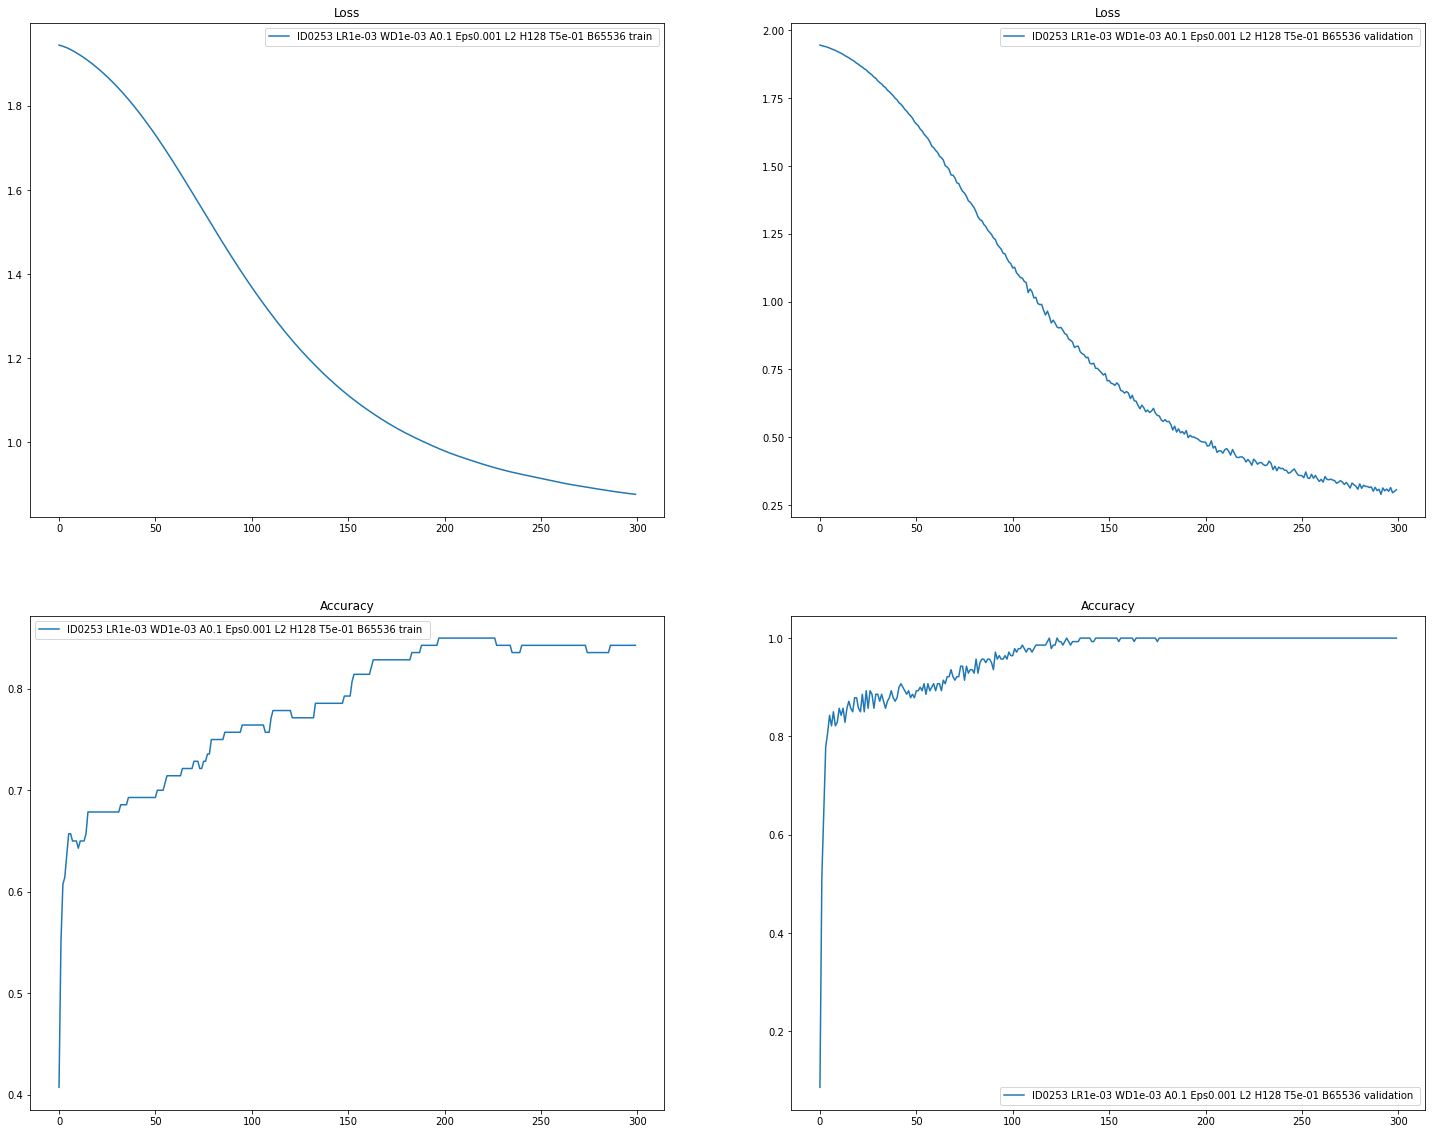

In [127]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(25, 20))
max_epoch_plot = 100
for i in ids:
    exp = seml_results.loc[i]
    exp_id = exp["_id"]
    lr = exp["config.train_params.lr"]
    weight_decay = exp["config.train_params.weight_decay"]
    alpha = exp["config.model_params.alpha"]
    eps = exp["config.model_params.eps"]
    nlayers = exp["config.model_params.nlayers"]
    hidden_size = exp["config.model_params.hidden_size"]
    temperature = exp["config.model_params.mean_kwargs.temperature"]
    batch_size = exp["config.train_params.batch_size"]
    name_suffix = f"ID{i:04d} LR{lr:.0e} WD{weight_decay:.0e} A{alpha:.02} Eps{eps:.02} L{nlayers} H{hidden_size:03d} T{temperature:.0e} B{batch_size:03d}"

    # epoch_num = exp["config.train_params.max_epochs"]
    # val_loss = epoch_mean(exp["result.trace_val.loss"], epoch_num)
    # val_acc = epoch_mean(exp["result.trace_val.acc"], epoch_num)
    # train_loss = epoch_mean(exp["result.trace_train.loss"], epoch_num)
    # train_acc = epoch_mean(exp["result.trace_train.acc"], epoch_num)

    val_loss = exp["result.trace_val.loss"]
    val_acc = exp["result.trace_val.acc"]
    train_loss =exp["result.trace_train.loss"]
    train_acc = exp["result.trace_train.acc"]
    max_epoch_plot = 1600 # len(train_loss)

    axs[0, 0].plot(train_loss[:], label= f"{name_suffix} train ")
    axs[0, 1].plot(val_loss[:], label= f"{name_suffix} validation ")
    axs[1, 0].plot(train_acc[:], label= f"{name_suffix} train ")
    axs[1, 1].plot(val_acc[:], label= f"{name_suffix} validation ")

axs[0, 0].set_title("Loss")
axs[0, 0].legend(loc="best")
axs[0, 1].set_title("Loss")
axs[0, 1].legend(loc="best")
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend(loc="best")
axs[1, 1].set_title("Accuracy")
axs[1, 1].legend(loc="best")
plt.show()

In [50]:
#exp
# _id config.model_params.nlayers  config.model_params.hidden_size config.model_params.mean_kwargs.temperature config.model_params.dropout

In [26]:
seml_results.loc[42]

_id                                                                                          165
batch_id                                                                                      15
slurm.experiments_per_job                                                                      1
slurm.sbatch_options.gres                                                                  gpu:1
slurm.sbatch_options.mem                                                                     32G
slurm.sbatch_options.cpus-per-task                                                             4
slurm.sbatch_options.time                                                                 0-6:00
slurm.sbatch_options.nodes                                                                     1
slurm.sbatch_options.job-name                                             rgnn_products_train_15
slurm.sbatch_options.array                                                                   0-0
slurm.sbatch_options.output   

In [43]:
from torch.utils.tensorboard import SummaryWriter
import math

        

log_dir = "../runs/papers100M_best"
for i in [233, 230, 165, 164, 116]: #range(100,len(seml_results)):
    exp = seml_results.loc[i]
    exp_id = exp["_id"]
    lr = exp["config.train_params.lr"]
    weight_decay = exp["config.train_params.weight_decay"]
    alpha = exp["config.model_params.alpha"]
    eps = exp["config.model_params.eps"]
    topk = exp["config.model_params.topk"]
    dropout = exp["config.model_params.dropout"]
    nlayers = exp["config.model_params.nlayers"]
    hidden_size = exp["config.model_params.hidden_size"]
    mean = exp["config.model_params.mean"]
    temp = exp["config.model_params.mean_kwargs.temperature"]
    batch_size = exp["config.train_params.batch_size"]
    label = exp["config.model_params.model"]

    if "config.train_params.use_annealing_scheduler" in exp.keys():
        use_annealing_scheduler = exp["config.train_params.use_annealing_scheduler"]
        if math.isnan(use_annealing_scheduler):
            use_annealing_scheduler = False
    else:
        use_annealing_scheduler = False
    if label == "PPRGo":
        label= "VanillaPPRGo" 
    print(use_annealing_scheduler)
    suffix = f"/{label}_alpha{alpha:.0e}_eps{eps:.0e}_topk{topk}_L{nlayers}_H{hidden_size:03d}_D{dropout}_T{temp:.0e}_{mean}_LR{lr:.0e}_WD{weight_decay:.0e}_S{use_annealing_scheduler:d}_B{batch_size:03d}_ID{exp_id}_{i}"
        

    print(suffix)
    
    # val_loss = exp["result.trace_val.loss"]
    # val_acc = exp["result.trace_val.acc"]
    # train_loss =exp["result.trace_train.loss"]
    # train_acc = exp["result.trace_train.acc"]
    train_loss = exp["result.trace_val.loss"]
    train_acc = exp["result.trace_val.acc"]
    val_loss =exp["result.trace_train.loss"]
    val_acc = exp["result.trace_train.acc"]

    writer = SummaryWriter(log_dir=log_dir + suffix)
    
    for step in range(len(train_loss)):
        #print(step)
        writer.add_scalar("Loss/train", train_loss[step], step)
        writer.add_scalar("Loss/validation", val_loss[step], step)
        writer.add_scalar("Accuracy/train", train_acc[step], step)
        writer.add_scalar("Accuracy/validation", val_acc[step], step)
        writer.add_scalar("Learning Rate", lr, step)

True
/RobustPPRGoDiffEmb_alpha2e-01_eps1e-04_topk64_L4_H512_D0.0_T5e+00_soft_median_LR5e-03_WD1e-04_S1_B4096_ID391_232
True
/RobustPPRGoDiffEmb_alpha2e-01_eps1e-04_topk64_L4_H512_D0.0_T1e+00_soft_median_LR5e-03_WD1e-04_S1_B4096_ID392_233
True
/RobustPPRGoDiffEmb_alpha2e-01_eps1e-04_topk64_L5_H320_D0.0_T1e+00_soft_median_LR5e-03_WD0e+00_S1_B8192_ID387_230
False
/VanillaPPRGo_alpha1e-01_eps1e-04_topk64_L3_H256_D0.0_Tnan_nan_LR1e-03_WD0e+00_S0_B10240_ID309_165
False
/VanillaPPRGo_alpha1e-01_eps1e-04_topk64_L3_H256_D0.0_Tnan_nan_LR5e-03_WD0e+00_S0_B10240_ID308_164
False
/VanillaPPRGo_alpha1e-01_eps1e-04_topk64_L3_H256_D0.0_Tnan_nan_LR5e-03_WD0e+00_S0_B10240_ID244_116


In [108]:
len(train_loss)

8646

In [98]:
range(240,len(seml_results))

range(240, 222)

True